In [1]:
# Copyright (c) MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Super-resolution using Stable Diffusion v2 Upscalers

Tutorial to illustrate the super-resolution task on medical images using Latent Diffusion Models (LDMs) [1]. For that, we will use an autoencoder to obtain a latent representation of the high-resolution images. Then, we train a diffusion model to infer this latent representation when conditioned on a low-resolution image.

To improve the performance of our models, we will use a method called "noise conditioning augmentation" (introduced in [2] and used in Stable Diffusion v2.0 and Imagen Video [3]). During the training, we add noise to the low-resolution images using a random signal-to-noise ratio, and we condition the diffusion models on the amount of noise added. At sampling time, we use a fixed signal-to-noise ratio, representing a small amount of augmentation that aids in removing artefacts in the samples.


[1] - Rombach et al. "High-Resolution Image Synthesis with Latent Diffusion Models" https://arxiv.org/abs/2112.10752

[2] - Ho et al. "Cascaded diffusion models for high fidelity image generation" https://arxiv.org/abs/2106.15282

[3] - Ho et al. "High Definition Video Generation with Diffusion Models" https://arxiv.org/abs/2210.02303

## Set up environment using Colab


In [2]:
!python -c "import monai" || pip install -q "monai-weekly[tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Set up imports

In [3]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import CacheDataset, DataLoader
from monai.utils import first, set_determinism
from torch import nn
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

from generative.losses import PatchAdversarialLoss, PerceptualLoss
from generative.networks.nets import AutoencoderKL, DiffusionModelUNet, PatchDiscriminator
from generative.networks.schedulers import DDPMScheduler

import pytorch_lightning as pl
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint

print_config()

/home/ol18/miniconda3/envs/monai_generative/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2023-04-07 18:33:20,193 - WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 1.13.1+cu117 with CUDA 1107 (you have 1.12.1)
    Python  3.8.16 (you have 3.8.16)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details
2023-04-07 18:33:21,929 - Created a temporary directory at /tmp/tmpq2wlch6q
2023-04-07 18:33:21,932 - Writing /tmp/tmpq2wlch6q/_remote_module_non_scriptable.py
MONAI version: 1.2.dev2304
Numpy version: 1.23.5
Pytorch version: 1.12.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 9a57be5aab9f2c2a134768c0c146399150e247a0
MONAI __file__: /home/ol18/miniconda3/envs/monai_generative/lib/python3.8/site-packages/monai_weekly-1.2.dev2304-py3.8.egg/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
ITK version: 5.3.

In [4]:
# for reproducibility purposes set a seed
set_determinism(42)

## Setup a data directory and download dataset
Specify a MONAI_DATA_DIRECTORY variable, where the data will be downloaded. If not specified a temporary directory will be used.

In [5]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmp1sbvw3_e


## Setup utils functions

In [6]:
def get_train_transforms():
    image_size = 64
    train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0,
                                        b_max=1.0, clip=True),
        transforms.RandAffined(
            keys=["image"],
            rotate_range=[(-np.pi / 36, np.pi / 36), (-np.pi / 36, np.pi / 36)],
            translate_range=[(-1, 1), (-1, 1)],
            scale_range=[(-0.05, 0.05), (-0.05, 0.05)],
            spatial_size=[image_size, image_size],
            padding_mode="zeros",
            prob=0.5,
        ),
        transforms.CopyItemsd(keys=["image"], times=1, names=["low_res_image"]),
        transforms.Resized(keys=["low_res_image"], spatial_size=(16, 16)),
    ]
    )
    return train_transforms

def get_val_transforms():
    val_transforms = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image"]),
            transforms.EnsureChannelFirstd(keys=["image"]),
            transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, 
                                            b_max=1.0, clip=True),
            transforms.CopyItemsd(keys=["image"], times=1, names=["low_res_image"]),
            transforms.Resized(keys=["low_res_image"], spatial_size=(16, 16)),
        ]
    )
    return val_transforms


## Define the LightningModule for AutoEncoder (transforms, network, loaders, etc)
The LightningModule contains a refactoring of your training code. The following module is a reformatiing of the code in 2d_stable_diffusion_v2_super_resolution.


In [7]:
class AutoEnconder(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.data_dir = root_dir
        self.autoencoderkl = AutoencoderKL(spatial_dims=2,
                                           in_channels=1,
                                           out_channels=1,
                                           num_channels=(256, 512, 512),
                                           latent_channels=3,
                                           num_res_blocks=2,
                                           norm_num_groups=32,
                                           attention_levels=(False, False, True))
        self.discriminator = PatchDiscriminator(spatial_dims=2, in_channels=1,
                                                num_layers_d=3, num_channels=64)
        self.perceptual_loss = PerceptualLoss(spatial_dims=2, network_type="alex")
        self.perceptual_weight = 0.002
        self.autoencoder_warm_up_n_epochs = 10
        self.automatic_optimization = False
        self.adv_loss = PatchAdversarialLoss(criterion="least_squares")
        self.adv_weight = 0.005
        self.kl_weight = 1e-6
        
    def forward(self, z):
        return self.autoencoderkl(z)

    def prepare_data(self):
        train_transforms = get_train_transforms()
        val_transforms = get_val_transforms()
        
        train_data = MedNISTDataset(root_dir=self.data_dir, section="training", download=True, seed=0)
        train_datalist = [{"image": item["image"]} for item in train_data.data if item["class_name"] == "HeadCT"]
        val_data = MedNISTDataset(root_dir=self.data_dir, section="validation", download=True, seed=0)
        val_datalist = [{"image": item["image"]} for item in val_data.data if item["class_name"] == "HeadCT"]
        
        self.train_ds = CacheDataset(data=train_datalist, transform=train_transforms)
        self.val_ds = CacheDataset(data=val_datalist, transform=val_transforms)
        
    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=16, shuffle=True,
                          num_workers=4, persistent_workers=True)
        
    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=16, shuffle=False,
                          num_workers=4)
                          
    def _compute_loss_generator(self, images, reconstruction, z_mu, z_sigma):
        recons_loss = F.l1_loss(reconstruction.float(), images.float())
        p_loss = self.perceptual_loss(reconstruction.float(), images.float())
        kl_loss = 0.5 * torch.sum(z_mu.pow(2) + z_sigma.pow(2) - torch.log(z_sigma.pow(2)) - 1, dim=[1, 2, 3])
        kl_loss = torch.sum(kl_loss) / kl_loss.shape[0]
        loss_g = recons_loss + (self.kl_weight * kl_loss) + (self.perceptual_weight * p_loss)
        return loss_g,recons_loss
    
    def _compute_loss_discriminator(self, reconstruction):
        logits_fake = discriminator(reconstruction.contiguous().detach())[-1]
        loss_d_fake = self.adv_loss(logits_fake, target_is_real=False, for_discriminator=True)
        logits_real = discriminator(images.contiguous().detach())[-1]
        loss_d_real = adv_loss(logits_real, target_is_real=True, for_discriminator=True)
        discriminator_loss = (loss_d_fake + loss_d_real) * 0.5
        loss_d = self.adv_weight * discriminator_loss
        return loss_d, discriminator_loss
        
    def training_step(self, batch, batch_idx):
        optimizer_g, optimizer_d = self.optimizers()
        images = batch["image"]
        reconstruction, z_mu, z_sigma = self.forward(images)
        loss_g, recons_loss = self._compute_loss_generator(images, reconstruction, z_mu, z_sigma)
        self.log("recons_loss", recons_loss, batch_size=16, prog_bar=True)

        if self.current_epoch > self.autoencoder_warm_up_n_epochs:
            logits_fake = discriminator(reconstruction.contiguous().float())[-1]
            generator_loss = adv_loss(logits_fake, target_is_real=True, for_discriminator=False)
            loss_g += adv_weight * generator_loss
                          

        self.log("loss_g", loss_g, batch_size=16, prog_bar=True)
        self.manual_backward(loss_g)
        optimizer_g.step()
        optimizer_g.zero_grad()
        self.untoggle_optimizer(optimizer_g)

        if self.current_epoch > self.autoencoder_warm_up_n_epochs:
            loss_d, discriminator_loss = self._compute_loss_discriminator(reconstruction)
            self.log("train_loss_d", loss_d, batch_size=16, prog_bar=True)
            self.manual_backward(loss_d)
            optimizer_d.step()
            optimizer_d.zero_grad()
            self.untoggle_optimizer(optimizer_d)

                          
        if self.current_epoch > self.autoencoder_warm_up_n_epochs:
            gen_epoch_loss += generator_loss.item()
            disc_epoch_loss += discriminator_loss.item()
            self.log("gen_loss", gen_loss, batch_size=16, prog_bar=True)
            self.log("disc_loss", disc_loss, batch_size=16, prog_bar=True)
                          
                                    
    def validation_step(self, batch, batch_idx):
        images = batch["image"]
        reconstruction, z_mu, z_sigma = self.autoencoderkl(images)
        recons_loss = F.l1_loss(images.float(), reconstruction.float())
        self.log("val_loss_d", recons_loss, prog_bar=True)
                              

    def configure_optimizers(self):
        optimizer_g = torch.optim.Adam(self.autoencoderkl.parameters(), lr=5e-5)
        optimizer_d = torch.optim.Adam(self.discriminator.parameters(), lr=1e-4)
        return [optimizer_g, optimizer_d], []
                          


## Train Autoencoder

In [8]:
n_epochs = 1
val_interval = 1

                          
# initialise the LightningModule
ae_net = AutoEnconder()

# set up checkpoints

checkpoint_callback = ModelCheckpoint(dirpath=root_dir, filename="best_metric_model")

                         
# initialise Lightning's trainer.
trainer = pl.Trainer(devices=1,
                     max_epochs=n_epochs,
                     check_val_every_n_epoch=val_interval,
                     callbacks=checkpoint_callback,
                     default_root_dir=root_dir)

# train
trainer.fit(ae_net)

The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.


2023-04-07 18:33:24,966 - GPU available: True (cuda), used: True
2023-04-07 18:33:24,967 - TPU available: False, using: 0 TPU cores
2023-04-07 18:33:24,968 - IPU available: False, using: 0 IPUs
2023-04-07 18:33:24,968 - HPU available: False, using: 0 HPUs


MedNIST.tar.gz: 59.0MB [00:02, 23.0MB/s]                                                                                                                                       

2023-04-07 18:33:27,673 - INFO - Downloaded: /tmp/tmp1sbvw3_e/MedNIST.tar.gz


2023-04-07 18:33:27,791 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2023-04-07 18:33:27,792 - INFO - Writing into directory: /tmp/tmp1sbvw3_e.


Loading dataset: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47164/47164 [00:40<00:00, 1177.19it/s]


2023-04-07 18:34:17,104 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2023-04-07 18:34:17,105 - INFO - File exists: /tmp/tmp1sbvw3_e/MedNIST.tar.gz, skipped downloading.
2023-04-07 18:34:17,107 - INFO - Non-empty folder exists in /tmp/tmp1sbvw3_e/MedNIST, skipped extracting.


Loading dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 972/972 [00:02<00:00, 442.12it/s]


2023-04-07 18:34:35,829 - Missing logger folder: /tmp/tmp1sbvw3_e/lightning_logs


Checkpoint directory /tmp/tmp1sbvw3_e exists and is not empty.


2023-04-07 18:34:37,274 - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
2023-04-07 18:34:37,290 - 
  | Name            | Type                 | Params
---------------------------------------------------------
0 | autoencoderkl   | AutoencoderKL        | 75.1 M
1 | discriminator   | PatchDiscriminator   | 2.8 M 
2 | perceptual_loss | PerceptualLoss       | 2.5 M 
3 | adv_loss        | PatchAdversarialLoss | 0     
---------------------------------------------------------
77.8 M    Trainable params
2.5 M     Non-trainable params
80.3 M    Total params
321.225   Total estimated model params size (MB)
Sanity Checking DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.30it/s]

Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 0: 100%|███████████████████████████████████████████████████████████████████████████████████| 500/500 [05:34<00:00,  1.50it/s, v_num=0, recons_loss=0.0421, loss_g=0.0443]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  69%|█████████████████████████████████████████████████████████████████████████████▊                                   | 42/61 [00:08<00:03,  4.93it/s]


Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:12<00:00,  4.84it/s]

Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 12. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 0: 100%|████████████████████████████████████████████████████████████████| 500/500 [05:49<00:00,  1.43it/s, v_num=0, recons_loss=0.0421, loss_g=0.0443, val_loss_d=0.0415]


## Rescaling factor

As mentioned in Rombach et al. [1] Section 4.3.2 and D.1, the signal-to-noise ratio (induced by the scale of the latent space) became crucial in image-to-image translation models (such as the ones used for super-resolution). For this reason, we will compute the component-wise standard deviation to be used as scaling factor.

In [9]:
train_loader = ae_net.train_dataloader()
check_data = first(train_loader)
z = ae_net.autoencoderkl.train(mode=False).encode_stage_2_inputs(check_data["image"].to(ae_net.device))
print(f"Scaling factor set to {1/torch.std(z)}")
scale_factor = 1 / torch.std(z)

Scaling factor set to 0.48439180850982666


## Define the LightningModule for DiffusionModelUnet (transforms, network, loaders, etc)
The LightningModule contains a refactoring of your training code. The following module is a reformatiing of the code in 2d_stable_diffusion_v2_super_resolution.

In [10]:
class DiffusionUNET(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.data_dir = root_dir
        self.unet = DiffusionModelUNet(
                                spatial_dims=2,
                                in_channels=4,
                                out_channels=3,
                                num_res_blocks=2,
                                num_channels=(256, 256, 512, 1024),
                                attention_levels=(False, False, True, True),
                                num_head_channels=(0, 0, 64, 64),
                            )
        self.max_noise_level = 350
        self.scheduler = DDPMScheduler(num_train_timesteps=1000, 
                          beta_schedule="linear",
                          beta_start=0.0015,
                          beta_end=0.0195)
        self.z = ae_net.autoencoderkl.train(mode=False)


    def forward(self, x, timesteps, low_res_timesteps):
        return self.unet(x=x, 
                         timesteps=timesteps,
                         class_labels=low_res_timesteps)
    
    
    def prepare_data(self):
        train_transforms = get_train_transforms()
        val_transforms = get_val_transforms()
        
        train_data = MedNISTDataset(root_dir=self.data_dir, section="training",
                                    download=True, seed=0)
        train_datalist = [{"image": item["image"]} for item in train_data.data if item["class_name"] == "HeadCT"]
        val_data = MedNISTDataset(root_dir=self.data_dir, section="validation",
                                  download=True, seed=0)
        val_datalist = [{"image": item["image"]} for item in val_data.data if item["class_name"] == "HeadCT"]
        
        self.train_ds = CacheDataset(data=train_datalist, transform=train_transforms)
        self.val_ds = CacheDataset(data=val_datalist, transform=val_transforms)
        
    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=16, shuffle=True,
                          num_workers=4, persistent_workers=True)
        
    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=16, shuffle=True,
                          num_workers=4)
    
    def _calculate_loss(self, batch, batch_idx):
        images = batch["image"]
        low_res_image = batch["low_res_image"]       
        latent = self.z.encode_stage_2_inputs(images) * scale_factor
        latent =  latent.detach() # avoid adding this to graph.
        optimizer = self.optimizers()
        
        # Noise augmentation
        noise = torch.randn_like(latent)
        low_res_noise = torch.randn_like(low_res_image)
        timesteps = torch.randint(0, self.scheduler.num_train_timesteps, (latent.shape[0],),
                                  device=latent.device).long()
        low_res_timesteps = torch.randint(
            0, self.max_noise_level, (low_res_image.shape[0],), device=latent.device
        ).long()

        noisy_latent = self.scheduler.add_noise(original_samples=latent, 
                                           noise=noise, timesteps=timesteps)
        noisy_low_res_image = self.scheduler.add_noise(
            original_samples=low_res_image, noise=low_res_noise, 
            timesteps=low_res_timesteps
        )

        latent_model_input = torch.cat([noisy_latent, noisy_low_res_image], dim=1)

        noise_pred = self.forward(latent_model_input, timesteps, low_res_timesteps)
        loss = F.mse_loss(noise_pred.float(), noise.float())
        return loss

    def training_step(self, batch, batch_idx):
        loss = self._calculate_loss(batch, batch_idx)
        self.log("train_loss", loss, batch_size=16, prog_bar=True)
        return loss

        
    def validation_step(self, batch, batch_idx):
        loss = self._calculate_loss(batch, batch_idx)
        self.log("val_loss", loss, batch_size=16, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.unet.parameters(), lr=5e-5)
        return optimizer


## Train Diffusion Model

In order to train the diffusion model to perform super-resolution, we will need to concatenate the latent representation of the high-resolution with the low-resolution image. For this, we create a Diffusion model with `in_channels=4`. Since only the outputted latent representation is interesting, we set `out_channels=3`.

As mentioned, we will use the conditioned augmentation (introduced in [2] section 3 and used on Stable Diffusion Upscalers and Imagen Video [3] Section 2.5) as it has been shown critical for cascaded diffusion models, as well for super-resolution tasks. For this, we apply Gaussian noise augmentation to the low-resolution images. We will use a scheduler low_res_scheduler to add this noise, with the t step defining the signal-to-noise ratio and use the t value to condition the diffusion model (inputted using class_labels argument).

In [11]:
n_epochs = 3
val_interval = 3

                          
# initialise the LightningModule
d_net = DiffusionUNET()

# set up checkpoints

checkpoint_callback = ModelCheckpoint(dirpath=root_dir, filename="best_metric_model_dunet")

                         
# initialise Lightning's trainer.
trainer = pl.Trainer(devices=1,
                     max_epochs=n_epochs,
                     check_val_every_n_epoch=val_interval,
                     callbacks=checkpoint_callback,
                     default_root_dir=root_dir)

# train
trainer.fit(d_net)

2023-04-07 18:40:37,435 - GPU available: True (cuda), used: True
2023-04-07 18:40:37,436 - TPU available: False, using: 0 TPU cores
2023-04-07 18:40:37,436 - IPU available: False, using: 0 IPUs
2023-04-07 18:40:37,437 - HPU available: False, using: 0 HPUs
2023-04-07 18:40:37,539 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2023-04-07 18:40:37,540 - INFO - File exists: /tmp/tmp1sbvw3_e/MedNIST.tar.gz, skipped downloading.
2023-04-07 18:40:37,541 - INFO - Non-empty folder exists in /tmp/tmp1sbvw3_e/MedNIST, skipped extracting.


Loading dataset: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47164/47164 [00:40<00:00, 1155.54it/s]


2023-04-07 18:41:19,165 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2023-04-07 18:41:19,165 - INFO - File exists: /tmp/tmp1sbvw3_e/MedNIST.tar.gz, skipped downloading.
2023-04-07 18:41:19,166 - INFO - Non-empty folder exists in /tmp/tmp1sbvw3_e/MedNIST, skipped extracting.


Loading dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 972/972 [00:02<00:00, 432.39it/s]


2023-04-07 18:41:38,130 - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
2023-04-07 18:41:38,161 - 
  | Name      | Type               | Params
-------------------------------------------------
0 | unet      | DiffusionModelUNet | 266 M 
1 | scheduler | DDPMScheduler      | 0     
2 | z         | AutoencoderKL      | 75.1 M
-------------------------------------------------
342 M     Trainable params
0         Non-trainable params
342 M     Total params
1,368.189 Total estimated model params size (MB)
Sanity Checking: 0it [00:00, ?it/s]

Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:22<00:00,  3.51it/s, v_num=1, train_loss=0.0418]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  69%|█████████████████████████████████████████████████████████████████████████████▊                                   | 42/61 [00:04<00:02,  8.42it/s]


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████| 500/500 [02:39<00:00,  3.13it/s, v_num=1, train_loss=0.0418, val_loss=0.113]


### Plotting sampling example

In [12]:
# Sampling image during training
num_samples = 3
val_loader = d_net.val_dataloader()
check_data = first(val_loader)
images = check_data["image"]
sampling_image = check_data["low_res_image"][:num_samples]

In [13]:
latents = torch.randn((num_samples, 3, 16, 16)).to(images.device)
low_res_noise = torch.randn((num_samples, 1, 16, 16)).to(images.device)
noise_level = 10
noise_level = torch.Tensor((noise_level,)).long().to(images.device)
scheduler = d_net.scheduler
noisy_low_res_image = scheduler.add_noise(original_samples=sampling_image, 
                                          noise=low_res_noise,
                                          timesteps=torch.Tensor((noise_level,)).long())

scheduler.set_timesteps(num_inference_steps=1000)
for t in tqdm(scheduler.timesteps, ncols=110):
    with torch.no_grad():
        with autocast(enabled=True):
            latent_model_input = torch.cat([latents, noisy_low_res_image], dim=1)
            noise_pred = d_net.forward(x=latent_model_input,
                                       timesteps=torch.Tensor((t,)),
                                       low_res_timesteps=noise_level)

        # 2. compute previous image: x_t -> x_t-1
        latents, _ = scheduler.step(noise_pred, t, latents)

with torch.no_grad():
    decoded = ae_net.autoencoderkl.decode_stage_2_outputs(latents / scale_factor)

100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [07:46<00:00,  2.14it/s]


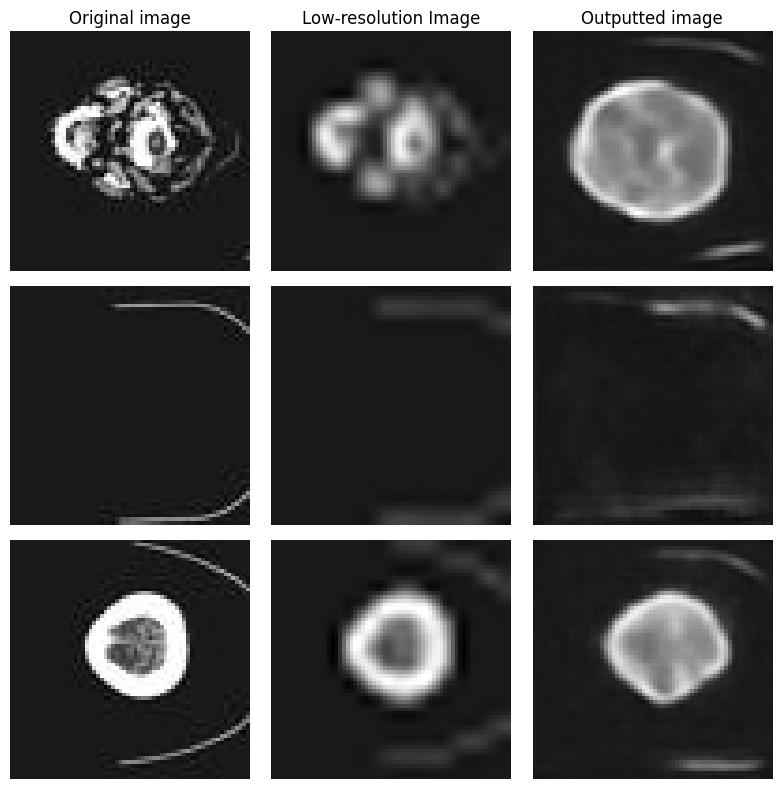

In [14]:
low_res_bicubic = nn.functional.interpolate(sampling_image, (64, 64), mode="bicubic")
fig, axs = plt.subplots(num_samples, 3, figsize=(8, 8))
axs[0, 0].set_title("Original image")
axs[0, 1].set_title("Low-resolution Image")
axs[0, 2].set_title("Outputted image")
for i in range(0, num_samples):
    axs[i, 0].imshow(images[i, 0].cpu(), vmin=0, vmax=1, cmap="gray")
    axs[i, 0].axis("off")
    axs[i, 1].imshow(low_res_bicubic[i, 0].cpu(), vmin=0, vmax=1, cmap="gray")
    axs[i, 1].axis("off")
    axs[i, 2].imshow(decoded[i, 0].cpu(), vmin=0, vmax=1, cmap="gray")
    axs[i, 2].axis("off")
plt.tight_layout()

### Clean-up data directory

In [15]:
if directory is None:
    shutil.rmtree(root_dir)